In [57]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from aparent.losses.aparent_losses import *

from visualization.seqprop_visualization import *
from generator.seqprop_generator import *
from predictor.seqprop_predictor import *
from predictor.definitions.aparent_legacy_without_padding_with_dense import load_saved_predictor
from optimizer.seqprop_optimizer import *


In [58]:
#Define target isoform loss function
def get_deepdream_loss(target_neuron) :

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, _, cut_pred, iso_score_pred, cut_score_pred, dense_out = predictor_outputs

        #Maximize dense neuron activation
        deepdream_loss = 1.0 * -K.mean(dense_out[..., target_neuron], axis=0)
        
        #Compute total loss
        total_loss = deepdream_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, library_context, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=185, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=False)#True
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode='pwm')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            #SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=False, isoform_start=80, isoform_end=115, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts



In [59]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models/legacy_models')
model_name = 'aparent_theano_legacy_30_31_34.h5'
model_path = os.path.join(save_dir, model_name)

In [60]:
#Optimize dense neuron activations for the 'Alien2' (aka 'Doubledope') library

seq_template = 'XXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTACG'
library_context = None

neuron_objectives = [25, 33, 20, 38]

#Run SeqProp Optimization

print("Running optimization experiment 'Alien2 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 20
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 4000

sequence_templates = [
    seq_template
    for target_neuron in neuron_objectives
]

losses = [
    get_deepdream_loss(target_neuron)
    for target_neuron in neuron_objectives
]

alien2_pwms, alien2_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



Running optimization experiment 'Alien2 Isoforms'
Optimizing objective 0...
Epoch 1/1
4000/4000 [==============================] - 78s 19ms/step - loss: -63.9409
Optimizing objective 1...
Epoch 1/1
4000/4000 [==============================] - 76s 19ms/step - loss: -46.8354
Optimizing objective 2...
Epoch 1/1
4000/4000 [==============================] - 81s 20ms/step - loss: -22.2383
Optimizing objective 3...
Epoch 1/1
4000/4000 [==============================] - 82s 21ms/step - loss: -104.8090


Dense Neuron 25


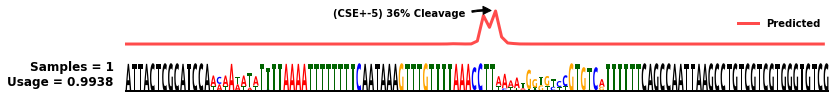

Dense Neuron 33


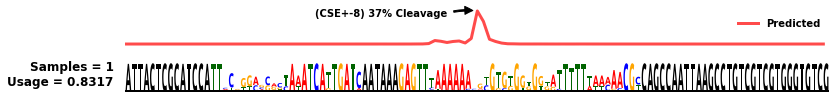

Dense Neuron 20


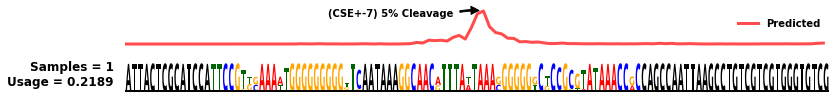

Dense Neuron 38


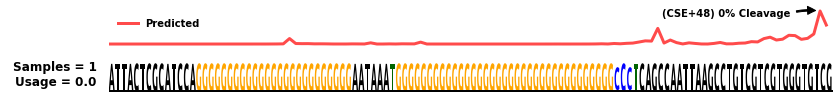

In [56]:
def get_consensus(pwm) :
    consensus_pwm = np.zeros(pwm.shape)
    for i in range(pwm.shape[0]) :
        j = np.argmax(pwm[i, :, 0])
        
        consensus_pwm[i, j, 0] = 1
    
    return consensus_pwm

#Plot average consensus PWM sequence logo per optimized objective (Experiment 'Alien2 Isoforms')

pwms = alien2_pwms
cuts = alien2_cuts

for obj_index, sequence_template in enumerate(sequence_templates) :
    
    print("Dense Neuron " + str(neuron_objectives[obj_index]))
    
    cons_pwms = np.concatenate([np.expand_dims(get_consensus(pwms[obj_index][k, :, :, :]), axis=0) for k in range(pwms[obj_index].shape[0])], axis=0)
    
    pwm = np.expand_dims(np.mean(cons_pwms[:, :, :, 0], axis=0), axis=0)
    cut = np.expand_dims(np.mean(cuts[obj_index][0, :, :], axis=0), axis=0)
    iso = np.expand_dims(np.sum(cut[:, 65:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-60, plot_end=76+50)


Dense Neuron 25


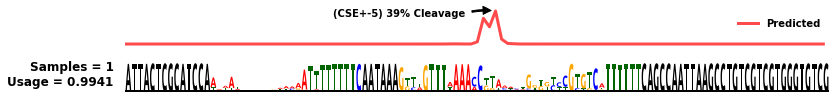

Dense Neuron 33


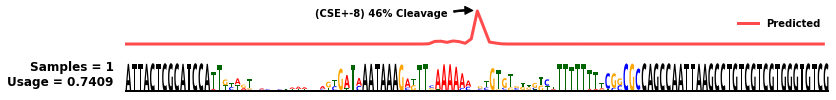

Dense Neuron 20


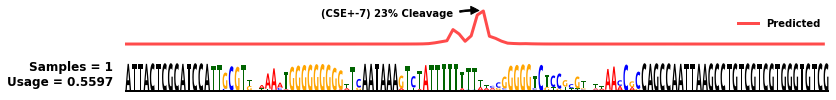

Dense Neuron 38


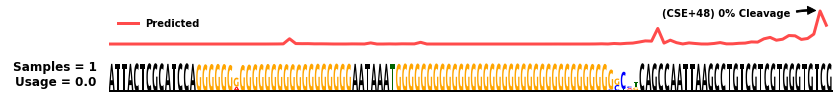

In [64]:
#Plot average (pooled) PWM sequence logo per optimized objective (Experiment 'Alien2 Isoforms')

pwms = alien2_pwms
cuts = alien2_cuts

for obj_index, sequence_template in enumerate(sequence_templates) :
    
    print("Dense Neuron " + str(neuron_objectives[obj_index]))
    
    pwm = np.expand_dims(np.sum(pwms[obj_index][:, :, :, 0], axis=0), axis=0)
    pwm[0, :, :] /= np.sum(pwm[0, :, :], axis=-1).reshape(-1, 1)
    
    cut = np.expand_dims(np.mean(cuts[obj_index][0, :, :], axis=0), axis=0)
    iso = np.expand_dims(np.sum(cut[:, 65:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-60, plot_end=76+50)
